<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Projeto_final/Exploratoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### Importação das bibliotecas e definição de funções

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
def fill_table(data):
    def fill_rows(rows):
        rows.loc[rows["ICU"] != 1] = rows.loc[rows["ICU"] != 1].fillna(method='bfill').fillna(method='ffill')
        # garante que só vai preencher as linhas em que o paciente ainda não foi pra UTI
        return rows
    
    cont_columns = data.iloc[:, 13:-2].columns # identificando o numero correto das colunas com dados que iremos preencher
    cont_features = data.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[list(cont_columns) + ["ICU"]].apply(fill_rows)
    cont_features.drop("ICU", axis=1, inplace=True)
    
    cat_features = data.iloc[:, :13]
    out = data.iloc[:, -2:]
    
    final_data = pd.concat([cat_features, cont_features, out], ignore_index=True, axis=1)
    final_data.columns = data.columns
    
    return final_data

In [3]:
def id_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

In [4]:
def remove_pts(data):
  remove = data.query("WINDOW == '0-2' and ICU == 1")["PATIENT_VISIT_IDENTIFIER"].values
  out = data.query("PATIENT_VISIT_IDENTIFIER not in @remove")
  return(out)

###### Importação dos dados

df_kg = dataframe do kaggle

In [5]:
#with pd.option_context('display.max_seq_items', None):
#    print (df_kg.columns)

In [6]:
df_kg = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")

In [7]:
df_kg.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [8]:
df_kg.iloc[:,0:13].isnull().any()

PATIENT_VISIT_IDENTIFIER    False
AGE_ABOVE65                 False
AGE_PERCENTIL               False
GENDER                      False
DISEASE GROUPING 1           True
DISEASE GROUPING 2           True
DISEASE GROUPING 3           True
DISEASE GROUPING 4           True
DISEASE GROUPING 5           True
DISEASE GROUPING 6           True
HTN                          True
IMMUNOCOMPROMISED            True
OTHER                        True
dtype: bool

Já tem dado faltante, o que vai enviesar minha análise, mesmo que pouco.

In [9]:
print(df_kg.isnull().sum())
print(f"Total = {df_kg.isnull().sum().sum()}") # numero de células dados faltantes

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     748
TEMPERATURE_DIFF_REL          694
OXYGEN_SATURATION_DIFF_REL    686
WINDOW                          0
ICU                             0
Length: 231, dtype: int64
Total = 223863


Antes de mais nada, o primeiro passo deve ser remover de prontidão todos os pacientes que deram entrada na UTI na primeira janela de tempo. Essa medida é baseada na recomendação do Sírio Libanês de utilizar somente os dados disponíveis **até o momento** da internação.

In [10]:
df_fill1 = remove_pts(df_kg)

Depois, faremos o preenchimento com backfill ou forwardfill, a depender da situação, mas sem utilizar os dados **após** o momento da internação. Como mencionado anteriormente, a recomendação é não utilizar esses valores, e também evitar usá-los como base para preencher os dados faltantes, pois não há como saber se as medidas associadas com a janela de internação foram realizadas logo antes, ou após o momento da internação.


In [11]:
df_fill2 = fill_table(df_fill1)

In [12]:
print(df_fill2.isnull().sum())
print(f"Total = {df_fill2.isnull().sum().sum()}") # numero de células dados faltantes

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     119
TEMPERATURE_DIFF_REL          101
OXYGEN_SATURATION_DIFF_REL     99
WINDOW                          0
ICU                             0
Length: 231, dtype: int64
Total = 36459


In [13]:
np.where(df_fill2.isnull())

(array([  53,   53,   53, ..., 1728, 1728, 1728]),
 array([ 13,  14,  15, ..., 190, 191, 192]))

In [14]:
df_fill2.iloc[50:55,]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
55,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.977720,-1.0,0.037037,-0.246154,-0.415094,-0.389831,0.785714,0.684211,0.037037,-0.246154,-0.415094,-0.379310,0.785714,0.684211,0.195876,-0.0125,-0.282051,-0.285714,0.868132,0.878788,-0.282051,-0.470270,-0.537313,-0.454545,0.449275,0.684211,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
56,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.977720,-1.0,0.037037,-0.246154,-0.415094,-0.389831,0.785714,0.684211,0.037037,-0.246154,-0.415094,-0.379310,0.785714,0.684211,0.195876,-0.0125,-0.282051,-0.285714,0.868132,0.878788,-0.282051,-0.470270,-0.537313,-0.454545,0.449275,0.684211,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
57,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.977720,-1.0,0.037037,-0.246154,-0.415094,-0.389831,0.785714,0.684211,0.037037,-0.246154,-0.415094,-0.379310,0.785714,0.684211,0.195876,-0.0125,-0.282051,-0.285714,0.868132,0.878788,-0.282051,-0.470270,-0.537313,-0.454545,0.449275,0.684211,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
58,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.456790,-0.338462,-0.396226,-0.050847,0.178571,0.736842,-0.456790,-0.338462,-0.396226,-0.034483,0.178571,0.736842,-0.216495,-0.0875,-0.264957,0.071429,0.494505,0.898990,-0.623932,-0.535135,-0.522388,-0.151515,-0.043478,0.736842,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,1
59,11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0

Valores faltantes aparecem na seguinte situação: se um paciente tem uma lacuna de medição exatamente na janela anterior à internação e possui dados após a internação, estes valores não serão utilizados para preencher a lacuna anterior. 

Vamos aplicar a próxima função que identifica quais pacientes deram entrada na UTI e utilizará somente os dados da primeira janela de tempo. É necessário fazer essa etapa somente depois de preencher dados faltantes, pois muitos pacientes podem ter medidas faltantes em janelas iniciais, mas ainda assim terem medidas em momentos anteriores à internação; que seriam perdidas.

In [15]:
df_fill3 = df_fill2.groupby("PATIENT_VISIT_IDENTIFIER").apply(id_window)

In [16]:
print(df_fill3.isnull().sum())
print(f"Total = {df_fill3.isnull().sum().sum()}") # numero de células dados faltantes

PATIENT_VISIT_IDENTIFIER       0
AGE_ABOVE65                    0
AGE_PERCENTIL                  0
GENDER                         0
DISEASE GROUPING 1             1
                              ..
RESPIRATORY_RATE_DIFF_REL     46
TEMPERATURE_DIFF_REL          39
OXYGEN_SATURATION_DIFF_REL    36
WINDOW                         0
ICU                            0
Length: 231, dtype: int64
Total = 4635


In [17]:
np.where(df_fill3.isnull())

(array([ 16,  16,  16, ..., 341, 341, 341]),
 array([193, 194, 195, ..., 226, 227, 228]))

In [18]:
df_fill3.iloc[16:20,:] # só para garantir que mostra como tabela

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,90,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.993216,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,1
19,95,19,1,70th,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.923600,-0.923600,...,-0.998073,-1.0,-0.234568,0.123077,-0.811321,-0.186441,-0.107143,0.842105,-0.234568,0.123077,-0.811321,-0.172414,-0.107143,0.842105,-0.030928,0.2875,-0.641026,-0.071429,0.318681,0.939394,-0.470085,-0.210811,-0.850746,-0.272727,-0.275362,0.842105,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
20,100,20,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.965463,-0.965463,...,-0.994912,-1.0,-0.037037,-0.553846,-0.547170,-0.593220,-0.250000,0.842105,-0.037037,-0.553846,-0.547170,-0.586207,-0.250000,0.842105,0.134021,-0.2625,-0.401709,-0.500000,0.230769,0.939394,-0.333333,-0.686486,-0.641791,-0.636364,-0.391304,0.842105,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
21,105,21,1,70th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.769634,-0.769634,-0.769634,-0.769634,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.268293,-0.268293,-0.268293,-0.268293,-1.0,-0.764521,-0.764521,...,-0.978029,-1.0,-0.358025,-0.800000,-0.320755,-0.525424,0.357143,0.684211,-0.358025,-0.800000,-0.320755,-0.517241,0.357143,0.684211,-0.134021,-0.4625,-0.196581,-0.428571,0.604396,0.878788,-0.555556,-0.859459,-0.462687,-0.575758,0.101449,0.684211,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0


In [19]:
df_kg.query("PATIENT_VISIT_IDENTIFIER == '18'")

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
90,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.993216,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
91,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
92,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.399177,-0.133333,-0.295597,-0.186441,0.178571,0.807018,0.382716,-0.076923,-0.415094,-0.034483,0.178571,0.842105,0.484536,-0.0125,-0.282051,-0.357143,0.494505,0.898990,-0.008547,-0.351351,-0.253731,-0.151515,-0.043478,0.842105,-0.965217,-0.865031,-0.709924,-0.647059,-1.000000,-0.959596,-0.977316,-0.876606,-0.766327,-0.736774,-1.000000,-0.960463,4-6,1
93,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.046154,-0.358491,-0.118644,0.142857,0.894737,0.333333,-0.046154,-0.358491,-0.103448,0.142857,0.894737,0.443299,0.1500,-0.230769,0.000000,0.472527,0.959596,-0.076923,-0.329730,-0.492537,-0.212121,-0.072464,0.894737,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,1
94,18,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.990518,-1.0,0.220576,-0.234359,-0.100629,-0.335593,-0.055952,0.726316,0.209877,-0.276923,-0.113208,-0.448276,-0.071429,0.710526,-0.072165,-0.1625,-0.213675,-0.714286,0.054945,0.858586,0.128205,-0.189189,0.074627,0.333333,0.130435,0.789474,-0.356522,-0.533742,-0.435115,0.117647,-0.380952,-0.939394,-0.545780,-0.530096,-0.627689,0.096774,-0.379238,-0.939126,ABOVE_12,1


Por último, existem pacientes que só tem medidas após a internação, e, nesse caso, deverão ser descartados, pois não é possível identificar corretamente quando as medidas foram tomadas; se logo após, logo antes ou durante o momento da internação.

In [20]:
df_fill4 = df_fill3.dropna()

In [21]:
df_fill4

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462

In [22]:
print(df_fill4.isnull().sum())
print(f"Total = {df_fill4.isnull().sum().sum()}") # numero de células dados faltantes

PATIENT_VISIT_IDENTIFIER      0
AGE_ABOVE65                   0
AGE_PERCENTIL                 0
GENDER                        0
DISEASE GROUPING 1            0
                             ..
RESPIRATORY_RATE_DIFF_REL     0
TEMPERATURE_DIFF_REL          0
OXYGEN_SATURATION_DIFF_REL    0
WINDOW                        0
ICU                           0
Length: 231, dtype: int64
Total = 0


In [23]:
df_fill4.shape

(294, 231)

Esse é o tamanho do dataset após as limpezas iniciais, mas ainda há chão!

Agora, quero examinar analisar as distribuições das variáveis categóricas, que obviamente não mudam entre as medições; e suas relações com as internações por covid.

In [24]:
df_final = df_fill4.reset_index(drop = True)

In [25]:
df_final

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-

In [26]:
df_final.loc[:,"ICU"].value_counts()

0    189
1    105
Name: ICU, dtype: int64

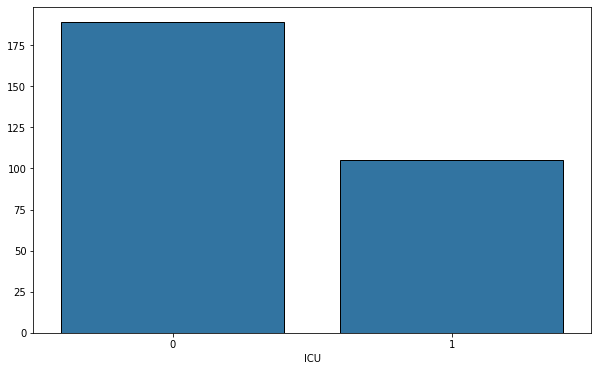

In [27]:
plt.figure(figsize = (10, 6))
sns.barplot(data = df_final, x = "ICU", y = df_final.index,
            ci = None, color = "#1f77b4", edgecolor = "black", estimator = len)

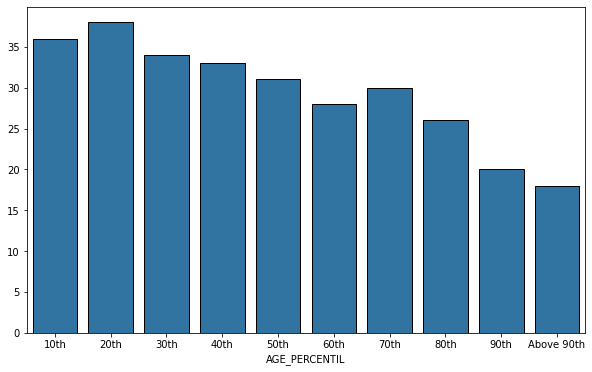

In [28]:
plt.figure(figsize = (10, 6))
sns.barplot(data = df_final, x = "AGE_PERCENTIL", y = df_final.index, 
            ci = None, color = "#1f77b4", edgecolor = "black", order = df_final.loc[:,"AGE_PERCENTIL"].sort_values().unique(),
            estimator = len)

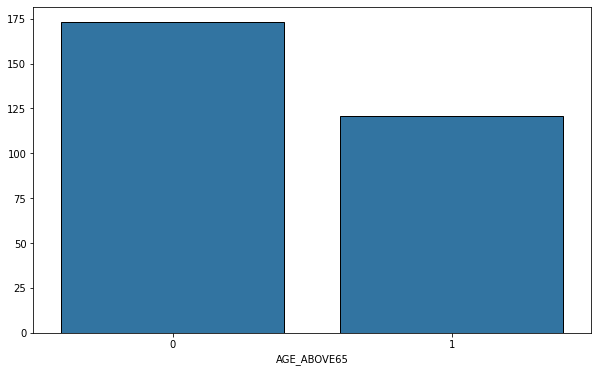

In [29]:
plt.figure(figsize = (10, 6))
sns.barplot(data = df_final, x = "AGE_ABOVE65", y = df_final.index, 
            ci = None, color = "#1f77b4", edgecolor = "black", estimator = len)

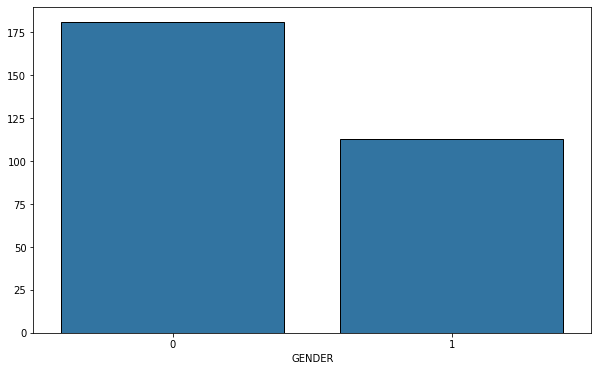

In [30]:
plt.figure(figsize = (10, 6))
sns.barplot(data = df_final, x = "GENDER", y = df_final.index, 
            ci = None, color = "#1f77b4", edgecolor = "black",
            estimator = len)

0 = masculino
1 = feminino

In [31]:
df_final.loc[:,"DISEASE GROUPING 1" : "DISEASE GROUPING 6"].sum()

DISEASE GROUPING 1    28.0
DISEASE GROUPING 2     7.0
DISEASE GROUPING 3    25.0
DISEASE GROUPING 4     6.0
DISEASE GROUPING 5    34.0
DISEASE GROUPING 6    14.0
dtype: float64

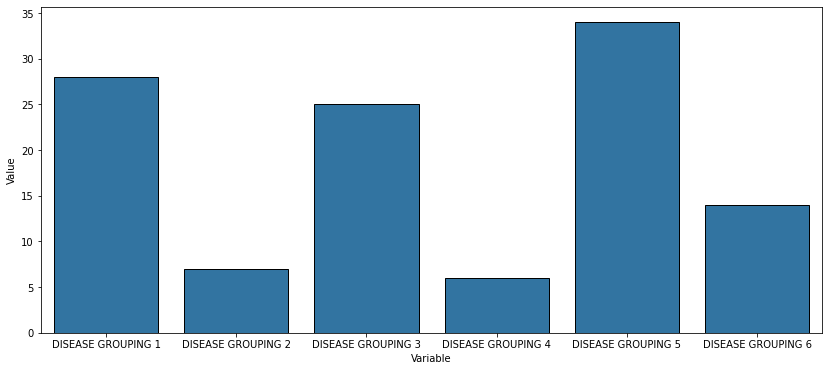

In [32]:
plt.figure(figsize = (14, 6))
sns.barplot(data = df_final.loc[:,"DISEASE GROUPING 1":"DISEASE GROUPING 6"].melt().rename(columns = str.title),
            x = "Variable", y = "Value", 
            ci = None, color = "#1f77b4", edgecolor = "black", estimator = sum)

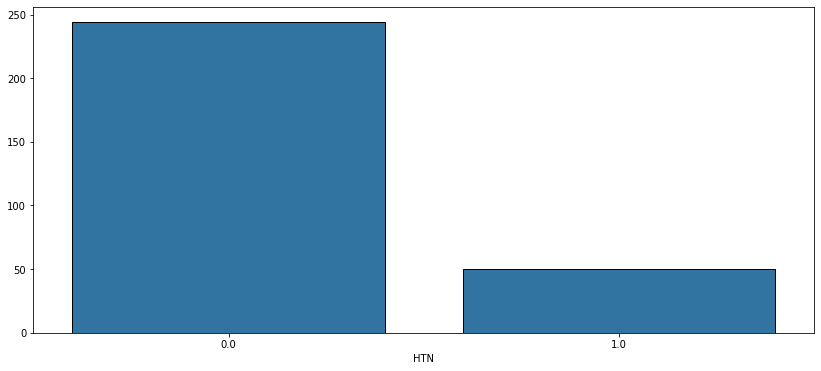

In [33]:
plt.figure(figsize = (14, 6))
sns.barplot(data = df_final,
            x = "HTN", y = df_final.index, 
            ci = None, color = "#1f77b4", edgecolor = "black", estimator = len)

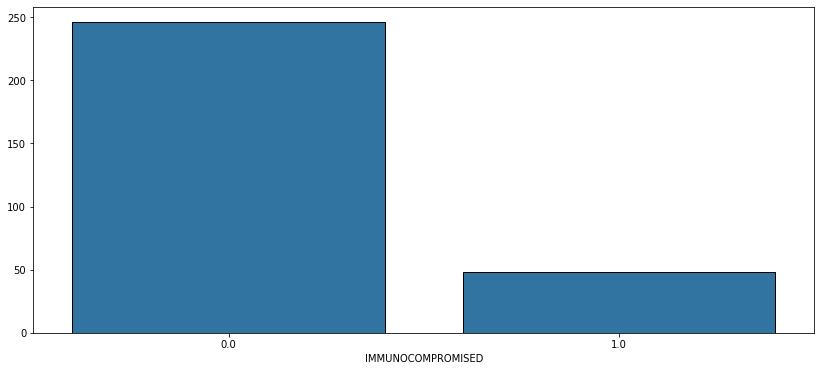

In [34]:
plt.figure(figsize = (14, 6))
sns.barplot(data = df_final,
            x = "IMMUNOCOMPROMISED", y = df_final.index, 
            ci = None, color = "#1f77b4", edgecolor = "black", estimator = len)

Os valores parecem bem semelhantes, será que todas as pessoas imunocomprimidas também apresentam hipertensão?

In [35]:
print(df_final.loc[:,"HTN"].value_counts())
print()
print(df_final.loc[:,"IMMUNOCOMPROMISED"].value_counts())

0.0    244
1.0     50
Name: HTN, dtype: int64

0.0    246
1.0     48
Name: IMMUNOCOMPROMISED, dtype: int64


In [36]:
np.where(df_final["HTN"] == df_final["IMMUNOCOMPROMISED"], True, False)

array([ True,  True, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False, False,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True, False,
        True,  True,

Parece que não. Acredito que essa seja a primeira etapa para verificar como essas variáveis categóricas representam a distribuição do perfil dos pacientes. Próximo passo será identificar a distribuição dessas variáveis nas classes da nossa feature de pessoas internadas.

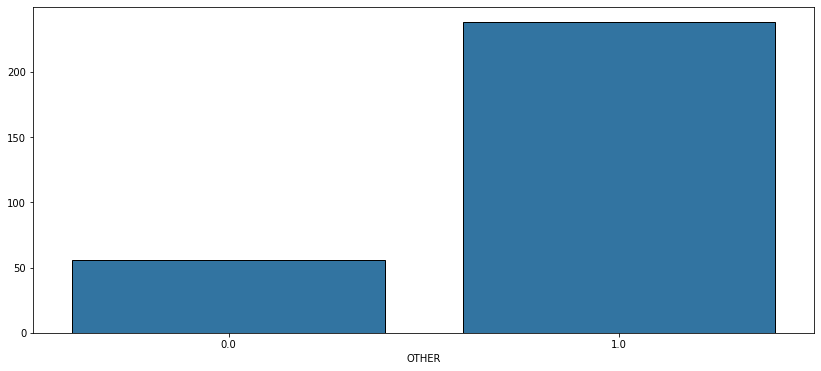

In [37]:
plt.figure(figsize = (14, 6))
sns.barplot(data = df_final,
            x = "OTHER", y = df_final.index, 
            ci = None, color = "#1f77b4", edgecolor = "black", estimator = len)

In [38]:
#bar1 = sns.barplot(data = df_final, x = "GENDER", y = df_final.index, 
#            estimator = len, ci = None, color = "darkblue")
#bar2 = sns.barplot(data = df_final[df_final.loc[:,"ICU"] == 1], x = "GENDER", y = df_final[df_final.loc[:,"ICU"] == 1].index, 
#            estimator = len, ci = None, color = "red")
#b1 = mpatches.Patch(color = "darkblue", label = "Total")

In [39]:
df_final.loc[:,"ICU"].value_counts()

0    189
1    105
Name: ICU, dtype: int64

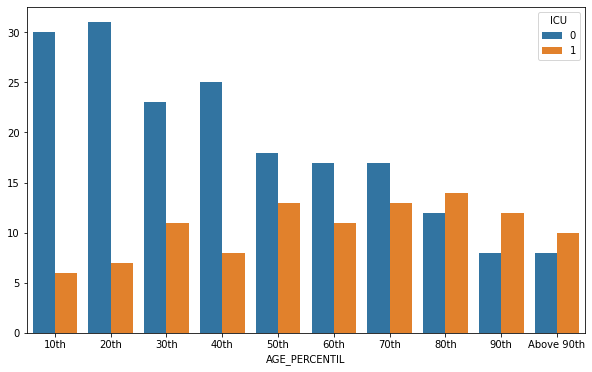

In [40]:
plt.figure(figsize = (10, 6))
sns.barplot(data = df_final, x = "AGE_PERCENTIL", y = df_final.index, 
            estimator = len, ci = None, hue = "ICU", 
            order = df_final.loc[:,"AGE_PERCENTIL"].sort_values().unique())

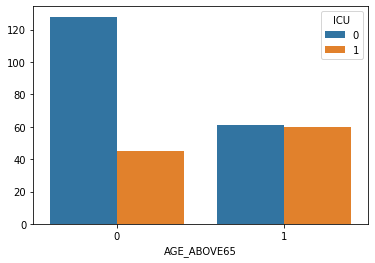

In [41]:
sns.barplot(data = df_final, x = "AGE_ABOVE65", y = df_final.index, 
            estimator = len, ci = None, hue = "ICU")

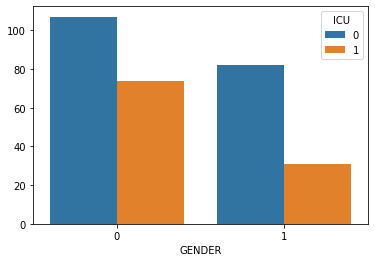

In [42]:
sns.barplot(data = df_final, x = "GENDER", y = df_final.index, 
            estimator = len, ci = None, hue = "ICU")

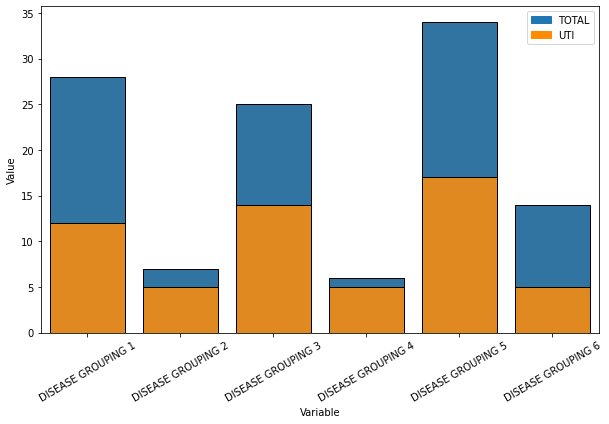

In [43]:
plt.figure(figsize = (10, 6))
bar1 = sns.barplot(data = df_final.iloc[:, 4:10].melt().rename(columns = str.title),
            x = "Variable", y = "Value", 
            ci = None, color = "#1f77b4", edgecolor = "black", estimator = sum)
bar2 = sns.barplot(data = df_final.query("ICU == 1").iloc[:,4:10].melt().rename(columns = str.title),
            x = "Variable", y = "Value", 
            ci = None, color = "darkorange", edgecolor = "black", estimator = sum)
plt.xticks(rotation = 30)
b1 = mpatches.Patch(color = "#1f77b4", label = "TOTAL")
b2 = mpatches.Patch(color = "darkorange", label = "UTI")
plt.legend(handles = [b1, b2])
plt.show()

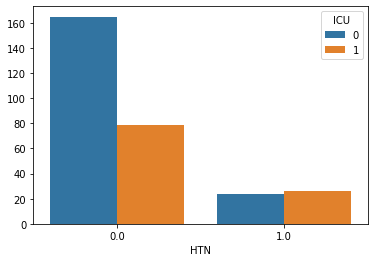

In [44]:
sns.barplot(data = df_final, x = "HTN", y = df_final.index, 
            estimator = len, ci = None, hue = "ICU")

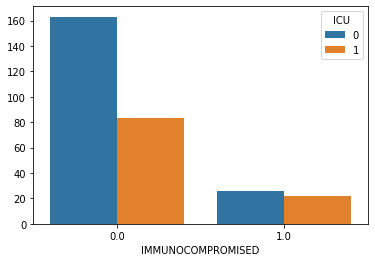

In [45]:
sns.barplot(data = df_final, x = "IMMUNOCOMPROMISED", y = df_final.index, 
            estimator = len, ci = None, hue = "ICU")

Agora, já deu de exploratória de categóricas, vamos para as contínuas. Bom, são muitas colunas e é inviável fazer qualquer inferência usando todas elas.

Uma última transformação necessária para melhor ajustar os dados de idade da coluna AGE PERCENTIL para a forma como serão trabalhados nos modelo de machine learning será utilizar o one-hot encoding:

In [64]:
df_final.loc[:,"AGE_PERCENTIL"] = df_final.AGE_PERCENTIL.astype("category").cat.codes
df_final

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.

In [65]:
with pd.option_context('display.max_seq_items', None):
   print (df_final.columns)

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN',
       'ALBUMIN_MIN', 'ALBUMIN_MAX', 'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN',
       'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX',
       'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BE_VENOUS_DIFF',
       'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN',
       'BIC_ARTERIAL_MAX', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN',
       'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX',
       'BIC_VENOUS_DIFF', 'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN',
       'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN',
       'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
       'CA

In [66]:
df_final.filter(regex = "_MEAN", axis = 1)
df_mean = df_final.filter(regex = "_MEAN", axis = 1)

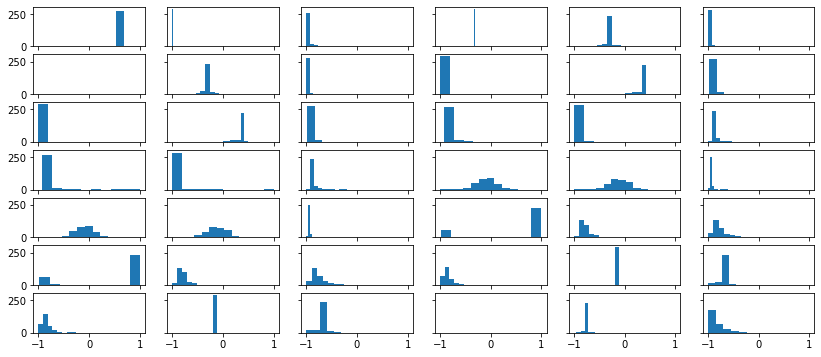

In [67]:
n_cols = df_mean.columns

fig, ax = plt.subplots(7, 6, sharex = True, sharey = True, figsize = (14, 6))


for i in range(7):
  for j in range(6):
    col_name = n_cols[i*3+j]
    ax[i,j].hist(df_mean[col_name])

plt.show()

(array([200.,  12.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.]),
 array([0.        , 0.0606431 , 0.12128621, 0.18192931, 0.24257242,
        0.30321552, 0.36385863, 0.42450173, 0.48514484, 0.54578794,
        0.60643105]),
 <a list of 10 Patch objects>)

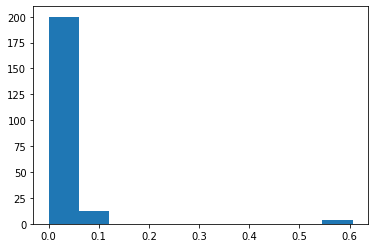

In [68]:
plt.hist(list(df_final.iloc[:,13:-2].var()))
#plt.hist(list(df_mean.var()))

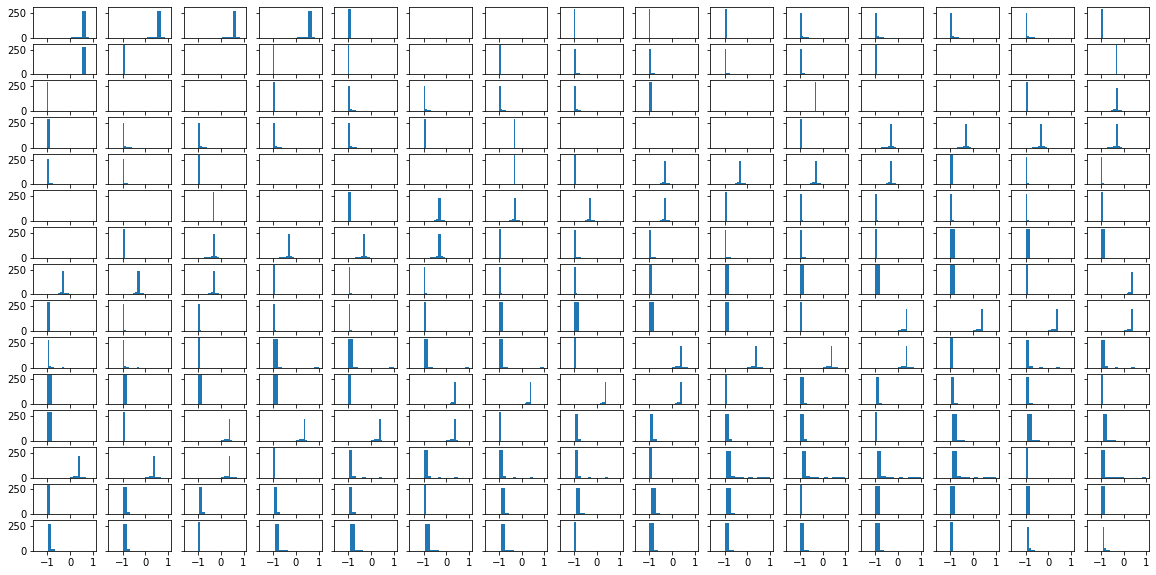

In [69]:
n_cols = df_final.iloc[:,13:-2].columns

fig, ax = plt.subplots(15, 15, sharex = True, sharey = True, figsize = (20, 10))


for i in range(15):
  for j in range(15):
    col_name = n_cols[i*3+j]
    ax[i,j].hist(df_final.iloc[:,13:-2][col_name])

plt.show()

Resumidamente, temos muitos dados com distribuições muito parecidas e muito próximas. Isso pode levar a uma grande taxa de falsos positivos devido às altas correlações entre as variáveis. A próxima etapa então é analisar diretamente estas correlações:

In [70]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 528.7+ KB


É improdutivo tentar qualquer visualização de correlação de tantas colunas assim. Podemos tentar com aquele objeto das médias de novo:

In [163]:
m_corr_means = df_mean.corr().abs()

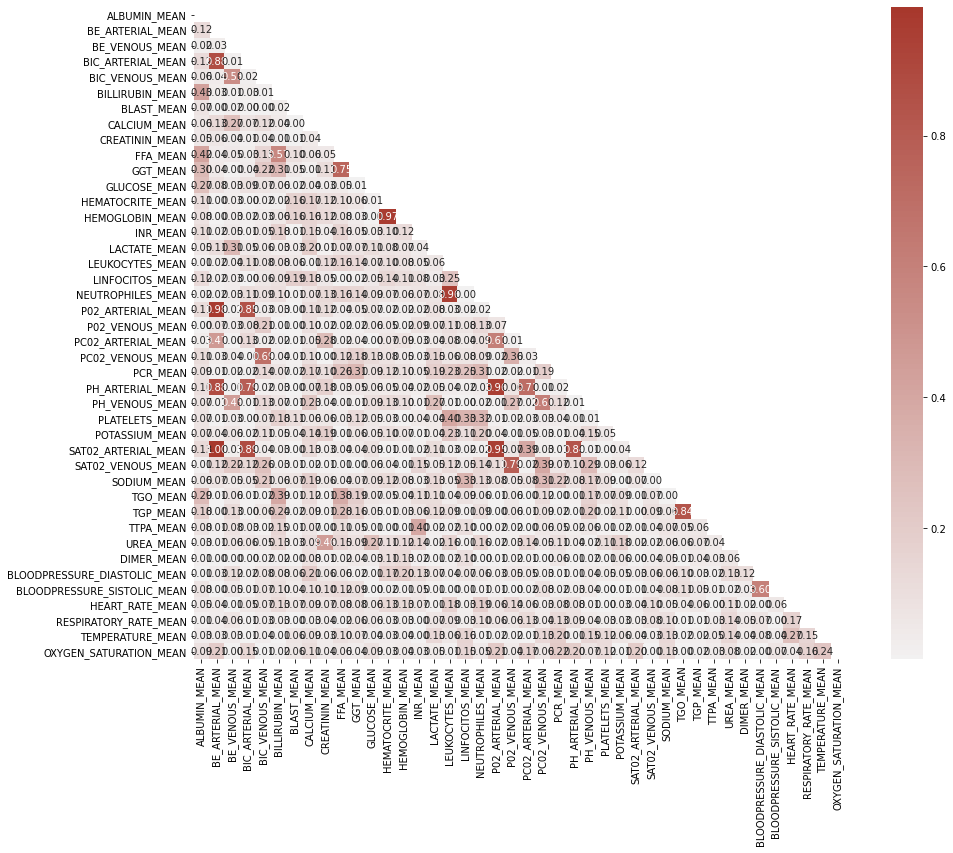

In [164]:
# Create a mask
plt.figure(figsize=(16,12))

mask = np.triu(np.ones_like(m_corr_means, dtype=bool))

sns.heatmap(m_corr_means, mask = mask, center = 0, annot = True,
             fmt = '.2f', square = True, cmap = cmap)

In [165]:
cont_features = df_final.iloc[:,13:-2]

In [167]:
m_corr = cont_features.corr().abs()
m_corr

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
ALBUMIN_MEDIAN,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MEAN,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MIN,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625,0.012909,0.029960,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.059970,0.061870,0.049816,0.055626,0.061170,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MAX,1.000000,1.000000,1.000000,1.000000,NaN,0.124220,0.124220,0.124220,0.124220,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.031620,0.089531,0.004730,0.075073,0.052625

-1.0    294
Name: ALBUMIN_DIFF, dtype: int64

In [168]:
m_corr_sup = m_corr.where(np.triu(np.ones(m_corr.shape).astype(np.bool), k = 1))
m_corr_sup # matriz superior

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
ALBUMIN_MEDIAN,NaN,1.0,1.0,1.0,NaN,0.12422,0.12422,0.12422,0.12422,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.03162,0.089531,0.00473,0.075073,0.052625,0.012909,0.02996,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.05997,0.06187,0.049816,0.055626,0.06117,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MEAN,NaN,NaN,1.0,1.0,NaN,0.12422,0.12422,0.12422,0.12422,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.03162,0.089531,0.00473,0.075073,0.052625,0.012909,0.02996,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.05997,0.06187,0.049816,0.055626,0.06117,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MIN,NaN,NaN,NaN,1.0,NaN,0.12422,0.12422,0.12422,0.12422,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.03162,0.089531,0.00473,0.075073,0.052625,0.012909,0.02996,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812,0.045535,0.098578,0.060128,0.063085,0.044019,0.05997,0.06187,0.049816,0.055626,0.06117,0.049501,0.066647,0.062262,0.048759
ALBUMIN_MAX,NaN,NaN,NaN,NaN,NaN,0.12422,0.12422,0.12422,0.12422,NaN,0.021082,0.021082,0.021082,0.021082,NaN,0.119674,0.119674,0.119674,0.119674,NaN,0.059078,0.059078,0.059078,0.059078,NaN,0.429199,0.429199,0.429199,0.429199,NaN,0.074625,0.074625,0.074625,0.074625,NaN,0.058743,0.058743,0.058743,0.058743,NaN,...,0.014923,0.014923,0.014923,NaN,0.005309,0.075161,0.054022,0.012347,0.03162,0.089531,0.00473,0.075073,0.052625,0.012909,0.02996,0.094916,0.010309,0.061219,0.063418,0.003386,0.018185,0.059149,0.019966,0.085883,0.042762,0.027812

In [141]:
m_corr_sup = m_corr.where(np.triu(np.ones(m_corr.shape).astype(np.bool), k = 1))
[column for column in m_corr_sup.columns if any(m_corr_sup[column] > 0.95)]

['ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEAN',
 'GLUCOSE_MIN',
 'GLUCOSE_MAX',
 'HEMATOCRITE_MEAN',
 'HEMATOCRITE_MIN',
 'HEMATOCRITE_MAX',
 'HEMOGLOBIN_MEDIAN',
 'HEMOGLOBIN_MEAN',
 'HEMOGLOBIN_MIN',
 'HEMOGLOBIN_MAX',
 'INR_MEAN',
 'INR_MIN',
 'INR_MAX',
 'LACTATE_MEAN',
 'LACTATE_MIN',
 'LACTATE_MAX',
 'LEUKOCYTES_MEAN',
 'LEUKOCYTES_MIN',
 'LEUKOCYTES_MAX',
 'LINFOCITOS_MEAN',
 'LINFOCITOS_MIN',
 'LINFOCITOS_MAX',
 'NEUTROPHILES_MEDIAN',
 'NEUTROPHILES_MEA

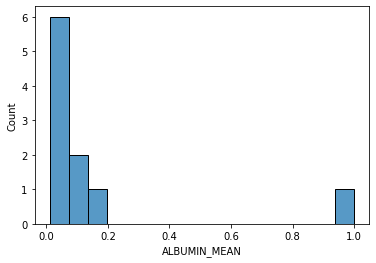

In [143]:
sns.histplot(m_corr_sup.loc[:,"ALBUMIN_MEAN"])

https://towardsdatascience.com/how-to-use-pairwise-correlation-for-robust-feature-selection-20a60ef7d10

https://www.kaggle.com/bbloggsbott/feature-selection-correlation-and-p-value